In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

## Data preprocessing

In [102]:
df = pd.read_csv('./train.csv')
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [103]:
enc_features = ['MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
               'LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual',
               'OverallCond','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','ExterQual',
               'ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
               'Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu',
               'GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature',
               'SaleType','SaleCondition']
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,2003,2003,196.0,706,0,150,856,856,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,1976,1976,0.0,978,0,284,1262,1262,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,2001,2002,162.0,486,0,434,920,920,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,1915,1970,0.0,216,0,540,756,961,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,2000,2000,350.0,655,0,490,1145,1145,...,0,0,0,1,0,0,0,0,1,0


In [104]:
real_features = ['LotFrontage','LotArea','YearBuilt','YearRemodAdd','MasVnrArea','BsmtFinSF1','BsmtUnfSF',
                'TotalBsmtSF','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath',
                'FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars',
                'GarageArea','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea',
                'MiscVal','MoSold','YrSold']
cat_features = list(set(df.columns.values.tolist()) - set(real_features))
cat_features.remove('SalePrice')
print (real_features)
print (cat_features)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
['BsmtFinType1_Unf', 'HouseStyle_SFoyer', 'Neighborhood_OldTown', 'Foundation_Stone', 'MSSubClass_80', 'ExterCond_Gd', 'Condition1_RRNn', 'BsmtExposure_No', 'PoolQC_Fa', 'Condition2_RRAe', 'FireplaceQu_TA', 'Exterior2nd_AsphShn', 'Exterior1st_Wd Sdng', 'GarageFinish_RFn', 'Exterior2nd_MetalSd', 'MSSubClass_90', 'SaleType_COD', 'SaleType_CWD', 'OverallQual_2', 'HeatingQC_Fa', 'CentralAir_N', 'Exterior1st_BrkFace', 'SaleCondition_Abnorml', 'OverallQual_9', 'Exterior2nd_HdBoard', 'LandSlope_Sev', 'BsmtFinSF2', 'OverallQual_6', 'MSSubClass_120', 'MSSubCla

In [105]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1971.267808,1984.865753,103.685262,443.639726,567.240411,1057.429452,1162.626712,346.992466,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,24.284752,9981.264932,30.202904,20.645407,181.066207,456.098091,441.866955,438.705324,386.587738,436.528436,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,21.000000,1300.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,59.000000,7553.500000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,69.000000,9478.500000,1973.000000,1994.000000,0.000000,383.500000,477.500000,991.500000,1087.000000,0.000000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11601.500000,2000.000000,2004.000000,166.000000,712.250000,808.000000,1298.250000,1391.250000,728.000000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,313.000000,215245.000000,2010.000000,2010.000000,1600.000000,5644.000000,2336.000000,6110.000000,4692.000000,2065.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [106]:
df[cat_features].describe()

,BsmtFinType1_Unf,HouseStyle_SFoyer,Neighborhood_OldTown,Foundation_Stone,MSSubClass_80,ExterCond_Gd,Condition1_RRNn,BsmtExposure_No,PoolQC_Fa,Condition2_RRAe,...,MasVnrType_None,Exterior2nd_Stone,Exterior2nd_Other,Neighborhood_BrDale,SaleType_ConLI,OverallCond_7,SaleType_New,MSZoning_RL,GarageFinish_Unf,RoofStyle_Gambrel
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.294521,0.025342,0.077397,0.004110,0.039726,0.100000,0.003425,0.652740,0.001370,0.000685,...,0.591781,0.003425,0.000685,0.010959,0.003425,0.140411,0.083562,0.788356,0.414384,0.007534
std,0.455983,0.157217,0.267312,0.063996,0.195382,0.300103,0.058440,0.476262,0.036999,0.026171,...,0.491673,0.058440,0.026171,0.104145,0.058440,0.347532,0.276824,0.408614,0.492784,0.086502
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
print (df.shape)

(1460, 320)


In [108]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0)    

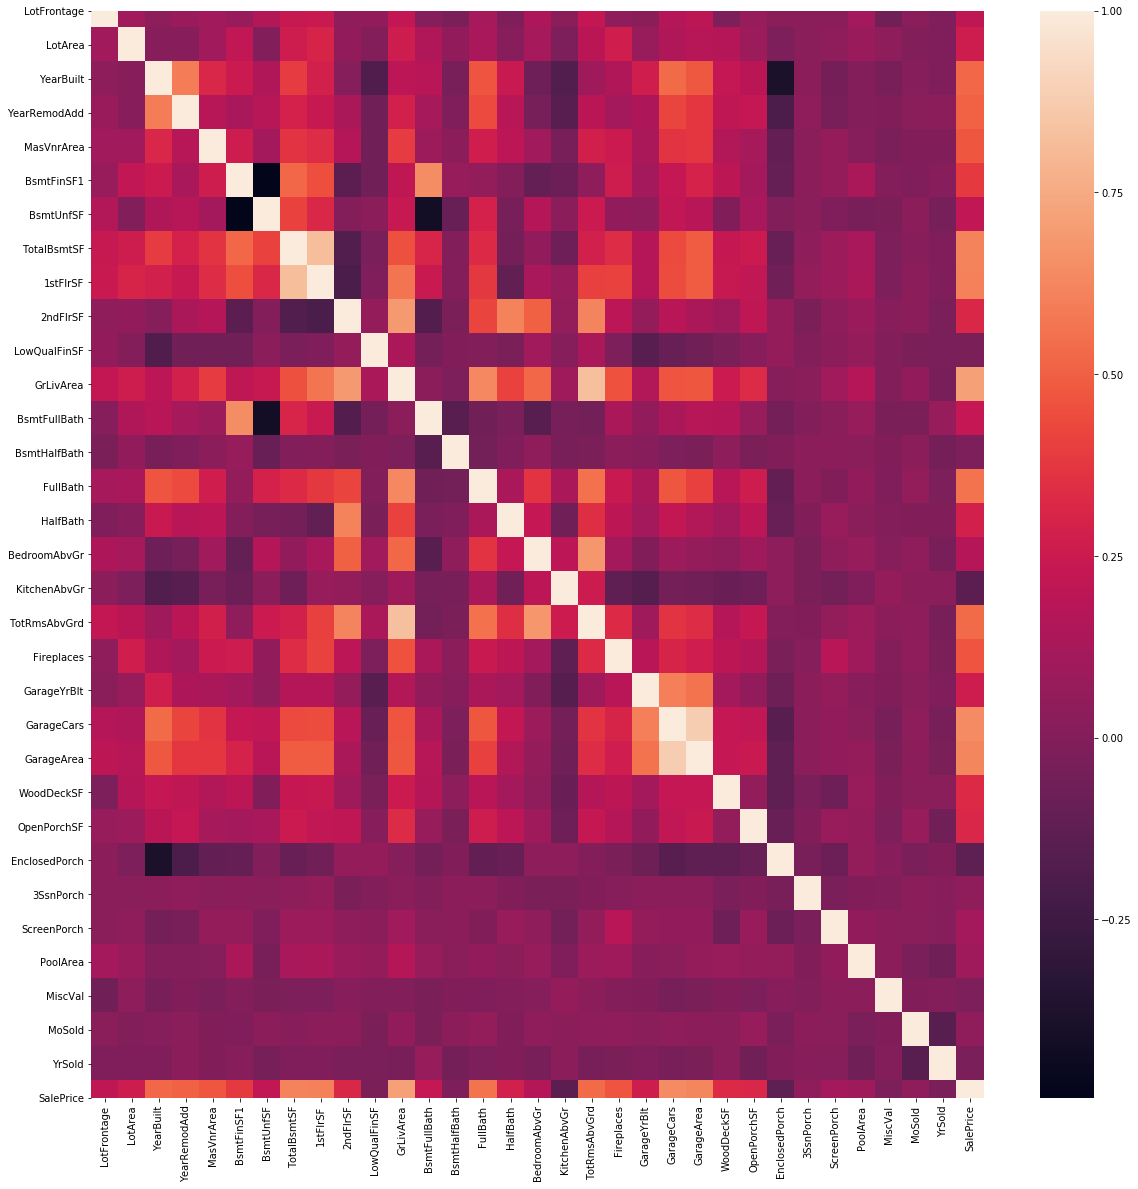

In [109]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[real_features + ['SalePrice']].corr())

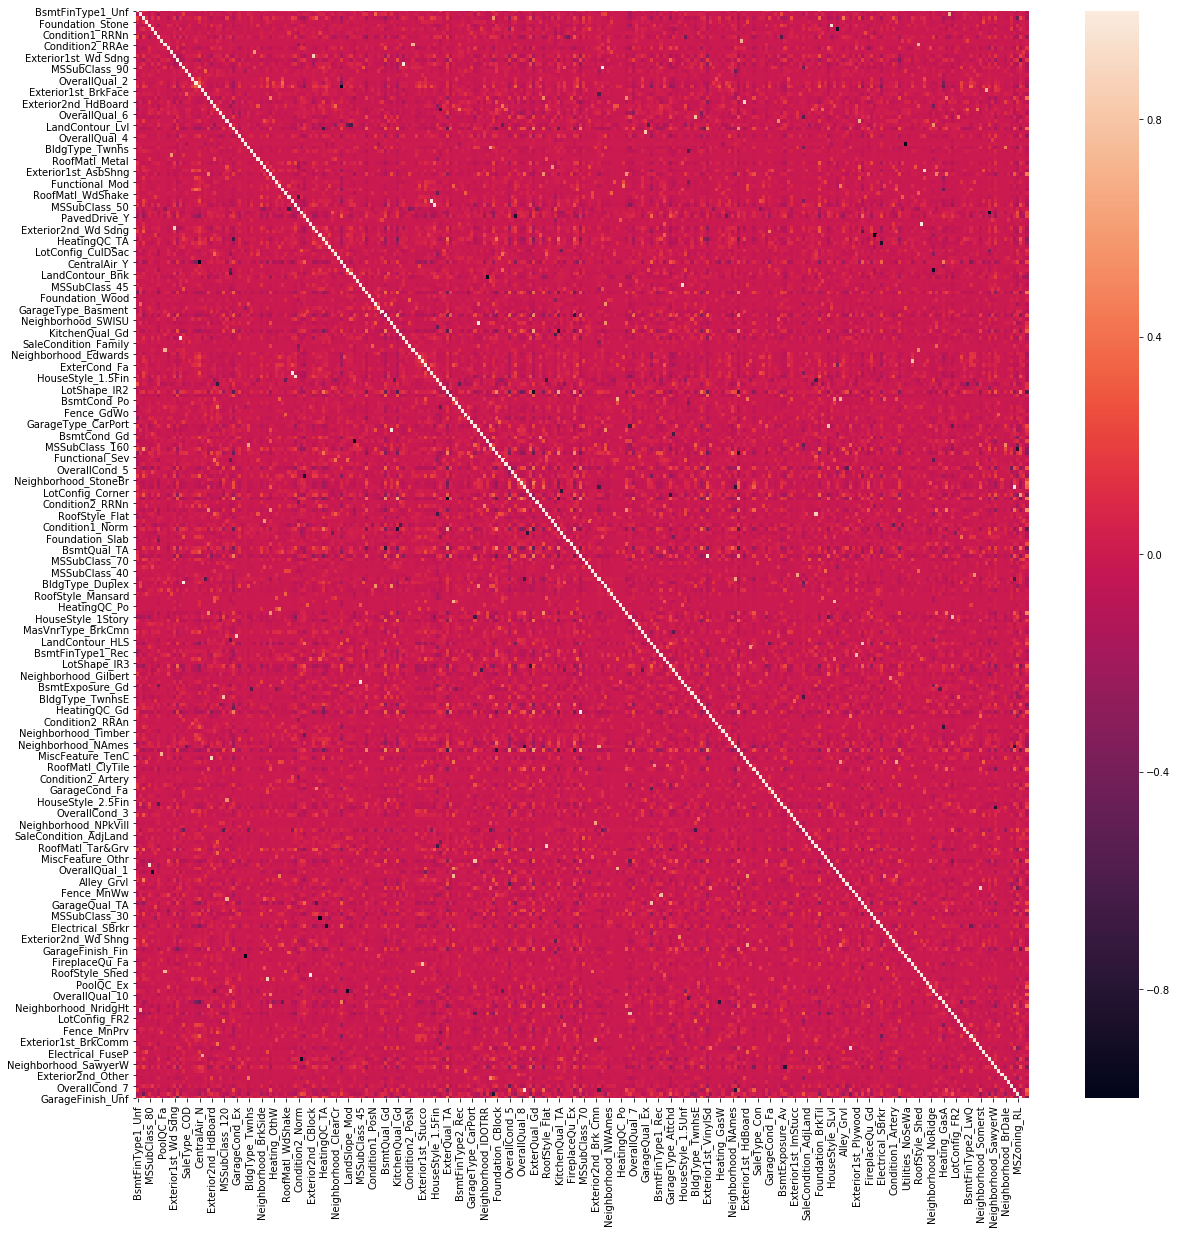

In [110]:
plt.figure(figsize=(20, 20))
sns.heatmap(df[cat_features + ['SalePrice']].corr())

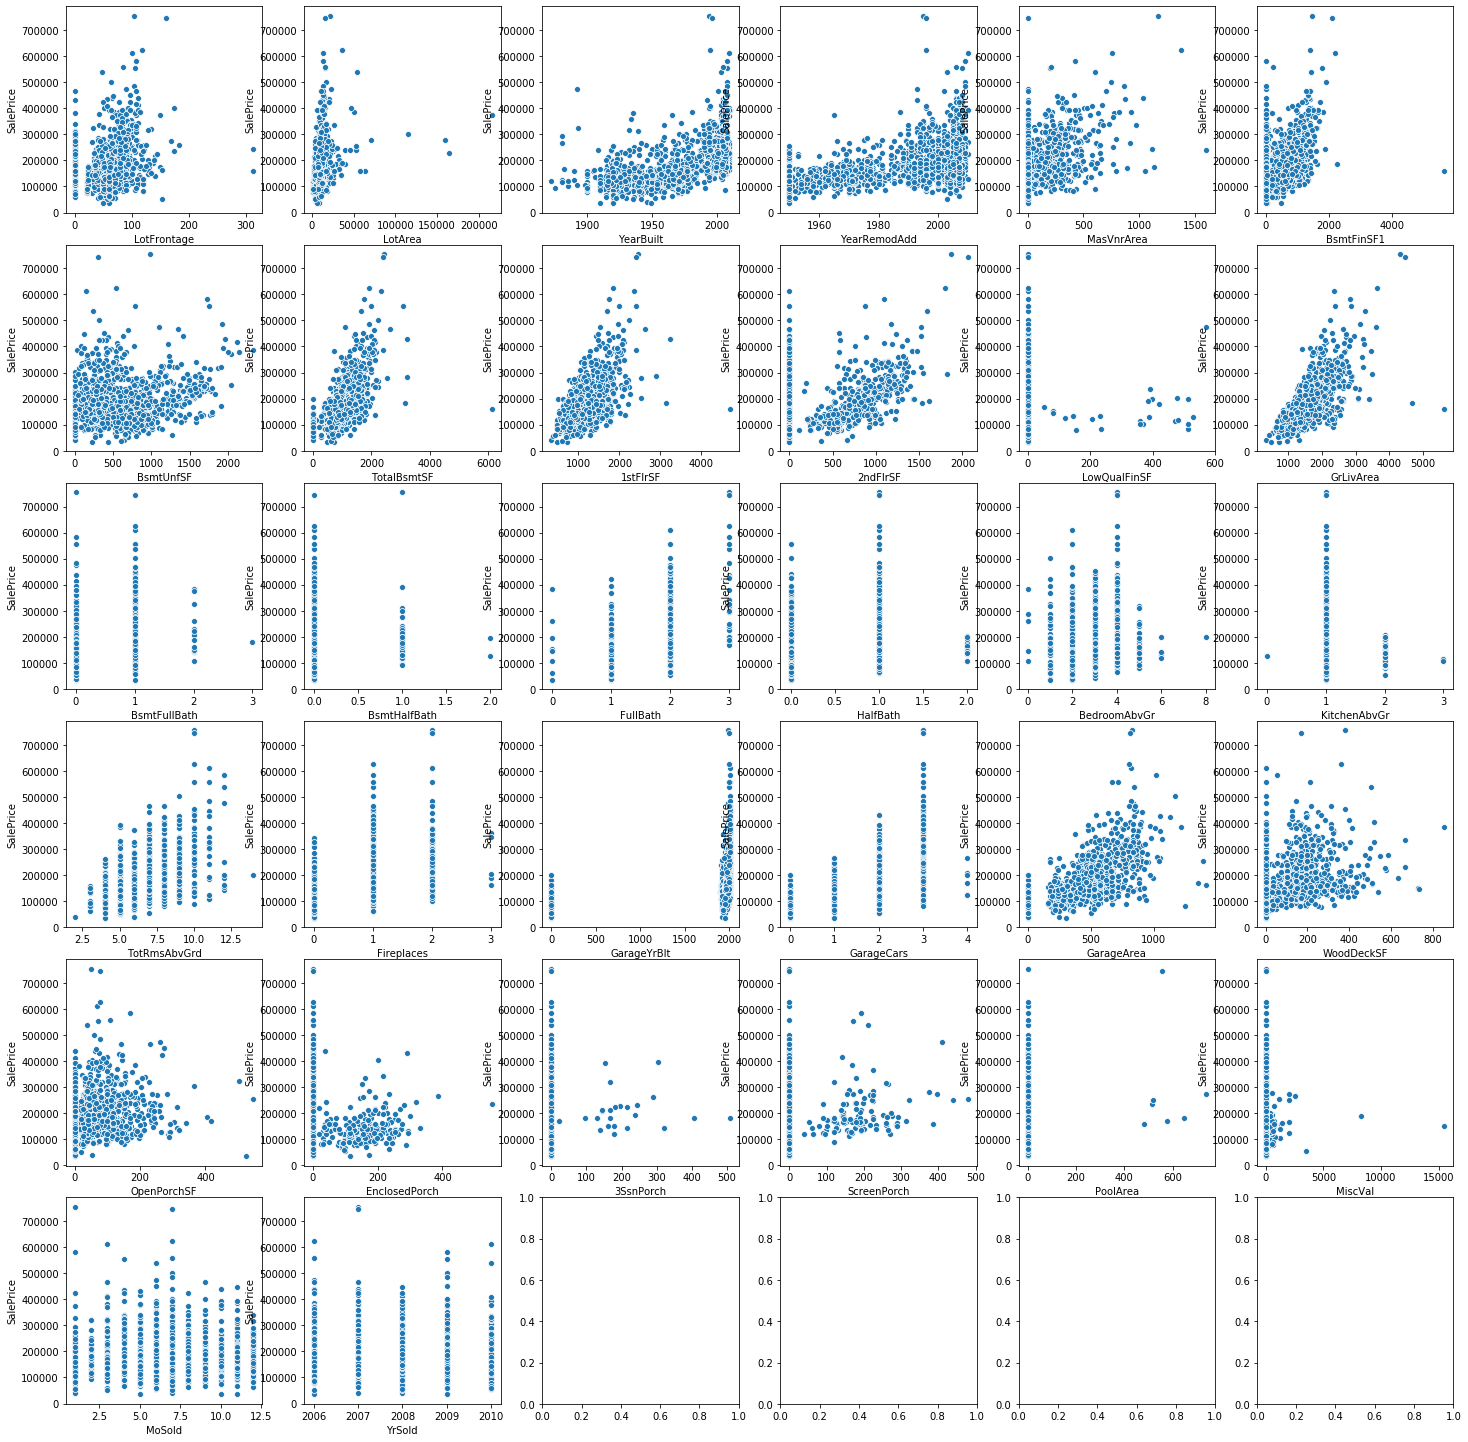

In [111]:
fig, ax = plt.subplots(6, 6, figsize=(20, 20))
fig.tight_layout()
ax = iter(ax.flatten())
for feat in real_features:
    sns.scatterplot(x=feat, y='SalePrice', data=df, ax=next(ax))

In [112]:
y = df['SalePrice'].to_numpy()
df = df.drop('SalePrice', 1)

X_real = df[real_features].to_numpy()
X_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_real[0]))
print ("X_cat: {} ".format(X_cat[0]))
print ("y: {} ".format(y[0]))

X_real: [6.500e+01 8.450e+03 2.003e+03 2.003e+03 1.960e+02 7.060e+02 1.500e+02
 8.560e+02 8.560e+02 8.540e+02 0.000e+00 1.710e+03 1.000e+00 0.000e+00
 2.000e+00 1.000e+00 3.000e+00 1.000e+00 8.000e+00 0.000e+00 2.003e+03
 2.000e+00 5.480e+02 0.000e+00 6.100e+01 0.000e+00 0.000e+00 0.000e+00
 0.000e+00 0.000e+00 2.000e+00 2.008e+03] 
X_cat: [0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0] 
y: 208500 


### Polynomial features

In [13]:
#transform = PolynomialFeatures(2)
#X_poly_real = transform.fit_transform(X_real)
X_poly_real = X_real

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_real_scaled = scaler.fit_transform(X_poly_real)

In [15]:
print (X_real_scaled.shape)
print (X_cat.shape)
print (y.shape)

(1460, 32)
(1460, 287)
(1460,)


### Checking dataset

In [16]:
#(X_train_real, X_test_real, X_train_cat, X_test_cat, 
# y_train, y_test) = train_test_split(X_real_scaled, X_cat, y, test_size=0.3, random_state=0)
#print (X_train_real.shape, X_test_real.shape)
#print (X_train_cat.shape, X_test_cat.shape)

#print (y_train.shape, y_test.shape)

In [17]:
#X_train = np.hstack((X_train_real, X_train_cat))
#X_test = np.hstack((X_test_real, X_test_cat))
X = np.hstack((X_real_scaled, X_cat))

In [18]:
xi = np.isfinite(X) 
print (xi[np.where(xi == False)].sum())

xn = np.isnan(X) 
print (xn[np.where(xn == False)].sum())

0
0


In [19]:
yi = np.isfinite(y) 
print (yi[np.where(yi == False)].sum())

yn = np.isnan(y) 
print (yn[np.where(yn == False)].sum())

0
0


## Features selection with Lasso

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, roc_auc_score
from sklearn.model_selection import cross_val_score

In [21]:
param_grid = {
    'alpha': [30.0], 'max_iter': [100000]
}
estimator = Lasso()

ls_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ls_model.fit(X, y)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    5.7s remaining:   13.2s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    6.6s remaining:    2.8s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.0s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [30.0], 'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [22]:
print (ls_model.best_estimator_)

Lasso(alpha=30.0, copy_X=True, fit_intercept=True, max_iter=100000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)


In [23]:
print (ls_model.best_score_)

0.8419909259646166


In [24]:
c = 0
not_null_idx = []
for cf in ls_model.best_estimator_.coef_:
    if cf != 0:
        not_null_idx.append(c)
    c += 1
print (len(not_null_idx))    
print (not_null_idx)    

178
[0, 1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 34, 37, 39, 40, 44, 45, 48, 53, 54, 55, 57, 58, 60, 61, 62, 63, 65, 68, 72, 75, 85, 87, 89, 90, 91, 94, 95, 100, 101, 102, 106, 107, 111, 112, 115, 116, 118, 119, 120, 122, 123, 128, 131, 132, 133, 135, 136, 137, 141, 142, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 158, 159, 162, 163, 165, 167, 171, 172, 173, 175, 176, 177, 178, 179, 183, 184, 185, 190, 191, 192, 193, 194, 195, 196, 197, 198, 200, 201, 204, 205, 206, 208, 209, 210, 212, 213, 214, 215, 217, 221, 222, 223, 224, 225, 226, 228, 230, 231, 236, 238, 242, 245, 247, 249, 250, 251, 252, 253, 258, 261, 262, 263, 267, 268, 270, 272, 276, 279, 281, 283, 287, 288, 290, 291, 292, 293, 294, 295, 296, 299, 300, 303, 304, 308, 309, 312, 314, 315]


In [25]:
X = X[:, not_null_idx]
print (X.shape)

(1460, 178)


## Linear regression

### Ridge

In [26]:
rg_model = Ridge(alpha=.5)

score = cross_val_score(rg_model, X, y, cv=10)
score_mean = score.mean()

In [27]:
print (score_mean)

0.8557798817286087


In [28]:
score = cross_val_score(rg_model, X, y, cv=5)
score_mean = score.mean()

In [29]:
print (score_mean)

0.8525695959211177


In [30]:
param_grid = {
    'alpha': [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 
              0.75, 0.8, 0.85, 0.9, 0.95, 1., 1.1, 1.2, 1.3, 1.4, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 10., 20., 30.],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}
estimator = Ridge()

rg2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rg2_model.fit(X, y)

Fitting 10 folds for each of 259 candidates, totalling 2590 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 226 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 405 tasks      | elapsed:   29.7s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 956 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1331 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1769 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2265 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 2590 out of 2590 | elapsed:  3.3min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.01, 0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.25,
                                   0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65,
                                   0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 1.1,
                                   1.2, 1.3, 1.4, 2.0, 3.0, 4.0, ...],
                         'solver': ['auto', 'svd', 'cholesky', 'lsqr',
                                    'sparse_cg', 'sag', 'saga']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [31]:
print (rg2_model.best_estimator_)

Ridge(alpha=4.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='sparse_cg', tol=0.001)


In [32]:
print (rg2_model.best_score_)

0.8616625680891966


### ElasticNet

In [33]:
el_model = ElasticNet(alpha=.5, l1_ratio=.5, max_iter=100000)

score = cross_val_score(el_model, X, y, cv=10)
score_mean = score.mean()

In [34]:
print (score_mean)

0.8195654465656155


In [35]:
score = cross_val_score(el_model, X, y, cv=5)
score_mean = score.mean()

In [36]:
print (score_mean)

0.8097744821831473


In [37]:
param_grid = {'alpha': [0.001, 0.01, 0.1, 0.5, 1., 5., 10., 20.],               
              'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7],
              'max_iter': [100000]}
estimator = ElasticNet()

el2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
el2_model.fit(X, y)

Fitting 10 folds for each of 40 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   12.8s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 20.0],
                         'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7],
                         'max_iter': [100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [38]:
print (el2_model.best_estimator_)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.7,
           max_iter=100000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


In [39]:
print (el2_model.best_score_)

0.8615441035800626


### LassoLars

In [40]:
la_model = LassoLars(alpha=.5, max_iter=30)

score = cross_val_score(la_model, X, y, cv=10)
score_mean = score.mean()

In [41]:
print (score_mean)

0.8073401763267419


In [42]:
score = cross_val_score(la_model, X, y, cv=5)
score_mean = score.mean()

In [43]:
print (score_mean)

0.8041708273101384


In [44]:
param_grid = {
    'alpha': [0.001, 0.01, 0.05, 0.07, 0.1, 0.2, 0.4, 0.5, 0.6, 0.7, 1.], 'max_iter': [40, 30, 20, 10]
}
estimator = LassoLars()

la2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
la2_model.fit(X, y)

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 208 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:    9.3s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LassoLars(alpha=1.0, copy_X=True,
                                 eps=2.220446049250313e-16, fit_intercept=True,
                                 fit_path=True, max_iter=500, normalize=True,
                                 positive=False, precompute='auto',
                                 verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.05, 0.07, 0.1, 0.2, 0.4, 0.5,
                                   0.6, 0.7, 1.0],
                         'max_iter': [40, 30, 20, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [45]:
print (la2_model.best_estimator_)

LassoLars(alpha=0.001, copy_X=True, eps=2.220446049250313e-16,
          fit_intercept=True, fit_path=True, max_iter=40, normalize=True,
          positive=False, precompute='auto', verbose=False)


In [46]:
print (la2_model.best_score_)

0.8283489520507891


## Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor

In [48]:
rf_model = RandomForestRegressor(max_depth=5, random_state=0, n_estimators=100)

score = cross_val_score(rf_model, X, y, cv=10)
score_mean = score.mean()

In [49]:
print (score_mean)

0.8156377274706832


In [50]:
param_grid = {
    'n_estimators': [100, 150, 200, 300, 400], 
    'max_depth': [2, 3, 4, 5, 10, 12, 13, 15],
    'min_samples_split': [2, 4, 5, 6, 10],
}
estimator = RandomForestRegressor()

rf2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
rf2_model.fit(X, y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 12.7min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 10, 12

In [51]:
print (rf2_model.best_estimator_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


In [52]:
print (rf2_model.best_score_)


0.8597777450661169


## ExtraTrees

In [53]:
from sklearn.ensemble import ExtraTreesRegressor

In [54]:
etr_model = ExtraTreesRegressor(n_estimators=100)

score = cross_val_score(etr_model, X, y, cv=10)
score_mean = score.mean()

In [55]:
print (score_mean)

0.8443565604474411


In [56]:
param_grid = {
    'max_depth': [10, 14, 15, 16, 18, 20],
    'min_samples_split': [2, 3, 4, 5, 10],
    'n_estimators': [100, 150, 200, 250, 300]
}
estimator = ExtraTreesRegressor()

etr2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
etr2_model.fit(X, y)        

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 12.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse',
                                           max_depth=None, max_features='auto',
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators='warn', n_jobs=None,
                                           oob_score=False, random_state=None,
                                           verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 14, 15, 16, 18, 20],
                         'min_samples_split': [2, 3, 4, 5, 

In [57]:
print (etr2_model.best_estimator_)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=18,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=3,
                    min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)


In [58]:
print (etr2_model.best_score_)

0.8492454515607604


## AdaBoost

In [59]:
from sklearn.ensemble import AdaBoostRegressor

In [60]:
ada_model = AdaBoostRegressor(n_estimators=100)

score = cross_val_score(ada_model, X, y, cv=10)
score_mean = score.mean()

In [61]:
print (score_mean)

0.7709760287151661


In [62]:
param_grid = {
    'loss': ['linear', 'square', 'exponential'],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.4, 0.5, 0.6, 0.7, 0.8, 1.],
    'n_estimators': [50, 100, 150, 200, 250, 300]
}
estimator = AdaBoostRegressor()

ada2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
ada2_model.fit(X, y)        

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed:  9.4min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='warn', n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.4, 0.5,
                                           0.6, 0.7, 0.8, 1.0],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [63]:
print (ada2_model.best_estimator_)

AdaBoostRegressor(base_estimator=None, learning_rate=0.4, loss='exponential',
                  n_estimators=50, random_state=None)


In [64]:
print (ada2_model.best_score_)

0.7848589672010052


## GradientBoosting

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

In [66]:
gb_model = GradientBoostingRegressor(n_estimators=100)

score = cross_val_score(gb_model, X, y, cv=10)
score_mean = score.mean()

In [67]:
print (score_mean)

0.873274411679029


In [68]:
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.09, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [100, 200, 300, 400, 500]
}
estimator = GradientBoostingRegressor()

gb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
gb2_model.fit(X, y)        

Fitting 10 folds for each of 270 candidates, totalling 2700 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 23.8min
[Parallel(n_jobs=-1)]: Done 2700 out of 2700 | elapsed: 25.2min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_ite...
                             

In [69]:
print (gb2_model.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=5,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [70]:
print (gb2_model.best_score_)

0.8985678150607634


## XGBoost

In [71]:
from xgboost import XGBRegressor

In [72]:
xgb_model = XGBRegressor()

score = cross_val_score(xgb_model, X, y, cv=10)
score_mean = score.mean()

[10:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:37:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [73]:
print (score_mean)

0.8724446982906935


In [74]:
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3],
    'gamma': [0.1, 0.2, 0.3],
    'colsample_bytree': [0.4, 0.5, 0.6],
    'n_estimators': [100, 200, 300, 400, 500]
}
estimator = XGBRegressor()

xgb2_model = GridSearchCV(estimator, param_grid, cv=10, n_jobs=-1, verbose=3)
xgb2_model.fit(X, y)

Fitting 10 folds for each of 810 candidates, totalling 8100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 4592 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 5392 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | e

[11:03:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='warn', n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6],
                         'gamma': [0.1, 0.2, 0.3],
                         'learning_rate': [0.1, 0.2, 0.3],
            

In [75]:
print (xgb2_model.best_estimator_)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0.1,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=3, missing=None, n_estimators=500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [76]:
print (xgb2_model.best_score_)

0.8939970269621734


## Voting

In [77]:
from sklearn.ensemble import VotingRegressor

In [93]:
best_models = [
    #('ls', ls_model), 
    ('rg', rg2_model),    
    ('xgb', xgb2_model),
    ('el', el2_model), 
    ('rf', rf2_model),
    ('gb', gb2_model),
    ('etr', etr2_model),
    #('ada', ada2_model),
]
best_estimators = []
for md in best_models:
    print ("{}_model: {}".format(md[0], md[1].best_score_))
    best_estimators.append((md[0], md[1].best_estimator_))

rg_model: 0.8616625680891966
xgb_model: 0.8939970269621734
el_model: 0.8615441035800626
rf_model: 0.8597777450661169
gb_model: 0.8985678150607634
etr_model: 0.8492454515607604


In [94]:
vt_model = VotingRegressor(best_estimators, n_jobs=-1)

print (vt_model)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=4.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='sparse_cg',
                                   tol=0.001)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.5, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=...
                                                       warm_start=False)),
                            ('etr',
                             ExtraTreesRegressor(bootstrap=False,
       

In [95]:
score = cross_val_score(vt_model, X, y, cv=10)
score_mean = score.mean()

In [96]:
print (score_mean)

0.8933649521704655


In [97]:
vt_model.fit(X, y)

VotingRegressor(estimators=[('rg',
                             Ridge(alpha=4.0, copy_X=True, fit_intercept=True,
                                   max_iter=None, normalize=False,
                                   random_state=None, solver='sparse_cg',
                                   tol=0.001)),
                            ('xgb',
                             XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=0.5, gamma=0.1,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=...
                                                       warm_start=False)),
                            ('etr',
                             ExtraTreesRegressor(bootstrap=False,
       

In [98]:
print (len(vt_model.estimators))

6


### LR submission

In [113]:
df_train = df.copy()

df = pd.read_csv('./test.csv')
house_ids = df['Id'].to_numpy()
df = df.drop('Id', 1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [114]:
for enc in enc_features:
    one_hot = pd.get_dummies(df[enc], prefix=enc)
    df = df.drop(enc,axis = 1)
    df = df.join(one_hot)
df.head()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,80.0,11622,1961,1961,0.0,468.0,144.0,270.0,882.0,896,...,0,0,0,1,0,0,0,0,1,0
1,81.0,14267,1958,1958,108.0,923.0,0.0,406.0,1329.0,1329,...,0,0,0,1,0,0,0,0,1,0
2,74.0,13830,1997,1998,0.0,791.0,0.0,137.0,928.0,928,...,0,0,0,1,0,0,0,0,1,0
3,78.0,9978,1998,1998,20.0,602.0,0.0,324.0,926.0,926,...,0,0,0,1,0,0,0,0,1,0
4,43.0,5005,1992,1992,0.0,263.0,0.0,1017.0,1280.0,1280,...,0,0,0,1,0,0,0,0,1,0


In [115]:
features_diff = list(set(df_train.columns.values.tolist()) - set(df.columns.values.tolist()))
print (len(features_diff), features_diff)
zeros = np.zeros(df.shape[0])

for ft in features_diff:
    df[ft] = pd.Series(zeros)

18 ['Condition2_RRAn', 'MiscFeature_TenC', 'RoofMatl_Membran', 'HouseStyle_2.5Fin', 'Exterior1st_ImStucc', 'Heating_Floor', 'RoofMatl_Roll', 'Electrical_Mix', 'Utilities_NoSeWa', 'Exterior1st_Stone', 'GarageQual_Ex', 'RoofMatl_Metal', 'RoofMatl_ClyTile', 'Exterior2nd_Other', 'PoolQC_Fa', 'Condition2_RRAe', 'Condition2_RRNn', 'Heating_OthW']


In [116]:
df[real_features].describe()

,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1232.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,1458.000000,1458.000000,1459.000000,1459.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,68.580357,9819.161069,1971.357779,1983.662783,100.709141,439.203704,554.294925,1046.117970,1156.534613,325.967786,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,22.376841,4955.517327,30.390071,21.130467,177.625900,455.268042,437.260486,442.898624,398.165820,420.610226,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,21.000000,1470.000000,1879.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,407.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,58.000000,7391.000000,1953.000000,1963.000000,0.000000,0.000000,219.250000,784.000000,873.500000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,67.000000,9399.000000,1973.000000,1992.000000,0.000000,350.500000,460.000000,988.000000,1079.000000,0.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,80.000000,11517.500000,2001.000000,2004.000000,164.000000,753.500000,797.750000,1305.000000,1382.500000,676.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,200.000000,56600.000000,2010.000000,2010.000000,1290.000000,4010.000000,2140.000000,5095.000000,5095.000000,1862.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [117]:
df[cat_features].describe()

,BsmtFinType1_Unf,HouseStyle_SFoyer,Neighborhood_OldTown,Foundation_Stone,MSSubClass_80,ExterCond_Gd,Condition1_RRNn,BsmtExposure_No,PoolQC_Fa,Condition2_RRAe,...,MasVnrType_None,Exterior2nd_Stone,Exterior2nd_Other,Neighborhood_BrDale,SaleType_ConLI,OverallCond_7,SaleType_New,MSZoning_RL,GarageFinish_Unf,RoofStyle_Gambrel
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.0,1459.0,...,1459.000000,1459.000000,1459.0,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,0.288554,0.031528,0.086361,0.003427,0.041124,0.104866,0.002742,0.651816,0.0,0.0,...,0.601782,0.000685,0.0,0.009596,0.002742,0.126799,0.080192,0.763537,0.428376,0.007539
std,0.453245,0.174801,0.280992,0.058460,0.198645,0.306486,0.052306,0.476558,0.0,0.0,...,0.489699,0.026180,0.0,0.097520,0.052306,0.332862,0.271683,0.425056,0.495013,0.086531
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,...,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,...,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [118]:
print (df.shape)

(1459, 320)


In [119]:
for ft in real_features:
    df[ft] = df[ft].fillna(0)
for ft in cat_features:
    df[ft] = df[ft].fillna(0) 

In [120]:
X_testing_real = df[real_features].to_numpy()
X_testing_cat = df[cat_features].to_numpy()

print ("X_real: {} ".format(X_testing_real[0]))
print ("X_cat: {} ".format(X_testing_cat[0]))

X_real: [8.0000e+01 1.1622e+04 1.9610e+03 1.9610e+03 0.0000e+00 4.6800e+02
 2.7000e+02 8.8200e+02 8.9600e+02 0.0000e+00 0.0000e+00 8.9600e+02
 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00 2.0000e+00 1.0000e+00
 5.0000e+00 0.0000e+00 1.9610e+03 1.0000e+00 7.3000e+02 1.4000e+02
 0.0000e+00 0.0000e+00 0.0000e+00 1.2000e+02 0.0000e+00 0.0000e+00
 6.0000e+00 2.0100e+03] 
X_cat: [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 144.   0.
   0.   0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   1.   0.
   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.
   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.  

In [121]:
#X_testing_poly_real = transform.fit_transform(X_testing_real)
X_testing_poly_real = X_testing_real

In [122]:
X_testing_real_scaled = scaler.fit_transform(X_testing_poly_real)

In [123]:
X_testing = np.hstack((X_testing_real_scaled, X_testing_cat))

X_testing = X_testing[:, not_null_idx]
print (X_testing.shape)

(1459, 178)


In [124]:
predicted = vt_model.predict(X_testing)

print (predicted)
print (house_ids)

[121874.61225898 152702.24723216 188311.97793967 ... 154684.74922368
 117767.99445088 228709.69268794]
[1461 1462 1463 ... 2917 2918 2919]


In [125]:
with open("submission_vt3.txt", "w") as fout:
    fout.write("Id,SalePrice\n")
    for val in zip(house_ids, predicted):
        fout.write("{},{}\n".format(str(int(val[0])), str(int(val[1]))))